# Brief user guide for the [**RandomForest2**](https://github.com/MNLR/RandomForest2) package 

This companion notebook briefly explains how to use the main functionalities provided by the `R` package [**RandomForest2**](https://github.com/MNLR/RandomForest2) and presents the code needed to reproduce one of the experiments presented in the article *Adapting Random Forests to Reliably Predict the Probability Distribution of Local Rainfall*, submitted to *Water Resources Research* by *Legasa et al.* In that work, random forests (RFs) are applied to the problem of statistical downscaling of rainfall. In particular, the authors analyze the suitability of different split functions which allow to work with non-normally distributed variable,s and propose a novel a posteriori (AP) approach which permits to accurately estimate the shape and rate parameters of the underlying rainfall distribution, which in turn allows for generating reliable stochastic rainfall series. 

[**RandomForest2**](https://github.com/MNLR/RandomForest2) requires a modified version of [rpart](https://cran.r-project.org/web/packages/rpart/index.html) which can be found [**here**](https://github.com/MNLR/rpart). In order to run the examples provided below, these two packages need to be first installed. This can be easily done from GitHub using the `devtools` package: 

In [ ]:
devtools::install_github("MNLR/rpart")
install.packages(c("progressr", "qmap", "fitdistrplus"))
devtools::install_github("MNLR/RandomForest2")

We start by loading `RandomForest2` and `VALUE9`, an dataset included in the package which contains daily series of rainfall for 9 illustrative meteorological stations over Europe along with the 17 large-scale reanalysis predictors used for statistical downscaling (see the paper for details).

In [1]:
library(RandomForest2)
data(VALUE9)

Loading required package: rpart

Loading required package: progressr



`VALUE9` is a list of 9 elements (one per station), being the data already divided into a stratified 5-fold (F1 = 1979-1984, F2 = 1985-1990, F3 = 1991-1996, F4 = 1997-2002, F5 = 2003-2008). `$train.y` and `$test.y` correspond to the predictands; `$train.x` (training set) and `$test.x` (testing set) are the predictors. For example:

In [2]:
head(cbind(VALUE9[[1]]$f1_79_84$train.y, VALUE9[[1]]$f1_79_84$train.x))

5.4,100934.56,101076.31,101029.38,101127.6,0.9725891,-0.5552429,3.362726,1.4769836,53970.78,⋯,0.0008774727,0.0007474154,0.001837683,0.001404357,0.002788675,0.002296162,0.003939099,0.003326243,0.004503078,0.004167265
3.0,99861.81,100098.66,99890.75,100026.2,4.0751587,2.3417603,6.654260,4.7987915,53126.36,⋯,0.0007746874,0.0008232652,0.002964854,0.003158688,0.002753138,0.002897739,0.004851500,0.004605810,0.004810254,0.004700223
5.0,100774.52,101000.39,101343.70,101556.2,1.7720581,0.8526245,3.237878,0.7207886,53762.79,⋯,0.0008526679,0.0009968218,0.002528636,0.002547173,0.002720682,0.002845912,0.004383934,0.003969920,0.004411114,0.003889335
12.9,100790.47,100810.84,101059.16,101159.5,4.7946411,4.9987427,7.108118,5.1798950,54141.42,⋯,0.0013121588,0.0011717600,0.002218187,0.002100289,0.002669751,0.002809047,0.004955770,0.004400434,0.005563976,0.005303564
11.0,99843.41,99968.94,100306.59,100510.2,8.2443481,8.8000122,9.919641,7.6437622,53829.54,⋯,0.0012456127,0.0012676665,0.003520003,0.003533235,0.004003754,0.004093757,0.006390568,0.006163236,0.006739852,0.006437775
1.0,99936.30,99915.36,100108.30,100281.5,7.5472656,9.0443359,10.253320,8.7977539,53769.01,⋯,0.0014264237,0.0015940617,0.003558955,0.004082522,0.003949782,0.004051825,0.005973617,0.006448189,0.006836812,0.006869952


## Training the models
To illustrate the training process, let's select the sixth station and first fold:

In [3]:
train.x <- VALUE9[[6]]$f1_79_84$train.x
train.y <- VALUE9[[6]]$f1_79_84$train.y

The function `randomForestTrain()` builds the model for the predictors `x` and predictands `y`.

In [4]:
rf <- randomForestTrain(x = train.x, y = train.y)

The user can specify the desired values for the parameters `mtry` (number of predictors to randomly use as candidate split variables), `ntree` (number of trees in the forest), `minbucket` (minimum number of elements each leaf is required to have), `minsplit` (minimum number of elements each node is required to have to attempt the splitting) and `maxdepth` (maximum depth allowed for each tree).

In [5]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 25, mtry = 22, 
                        minbucket = 10, minsplit = 30, maxdepth = 10)

By default, random forests consider the root mean squared error as split function. However, [RandomForest2](https://github.com/MNLR/RandomForest2) allows for using different split functions (`split.function` argument), which have been defined in the [modified version of `rpart`](https://github.com/MNLR/rpart). Currently supported options are `"anova", "poisson", "class", "exp", "gammaLLMME", "gammaLLmean", "bernoulliGammaLLMME", "gammaDeviation", "gammaLLBC3", "bernoulliLL"` and `"binaryCrossEntropyGammaDeviation"`. 

In this work we restrict ourselves to the 2-parameter gamma distribution family, with different estimators (see the paper for details).

In [6]:
rf.dev <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaDeviation")
rf.LLMME <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaLLMME")
rf.LLBC3 <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaLLBC3")

## Parallelization

The training process can be parallelized by means of the package `future.apply`. The package has to be installed independently, otherwise parallelization will not be an option. Use `install.packages(future.apply)` to install it. This will also install the dependency `future`. The simplest way to use parallelization is setting `parallel.plan = "auto"`. This will automatically use all the available cores to train the model in parallel.

In [7]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10,
                        method = "gammaDeviation",
                        parallel.plan = "auto")

If not set to `"auto"`, the parameter `paralell.plan` will use the execution plan stored in the `strategy` parameter in `future::plan()`. The interested reader is referred to the packages `future` and `future.apply` for the available options. As an example, the following block of code shows how parallelization in 4 cores can be achieved in combination with the parameter `workers` and setting the `parallel.plan` to `multisession`:

In [8]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, 
                        method = "gammaDeviation", 
                        parallel.plan = future::multisession, workers = 4)

Also, if missing or set to `NULL` (default), the function will use the current execution plan. This is useful to configure a customized plan outside the function, as we do in the next example. In particular, we set the execution to `multisession()` prior to launching the loop and train several models using this plan (do not forget to close the sessions by reverting to `sequential()`).

In [9]:
future::plan(future::multisession, workers = 4)

rfs <- lapply(VALUE9[[1]], function(fold){
    return(
        randomForestTrain(x = fold$train.x, y = fold$train.y, ntree = 25, minbucket = 10, 
                          method = "gammaDeviation",
                          parallel.plan = NULL)
    )
    
})

future::plan(future::sequential)

Note that using `parallel.plan = NA` will avoid parallelization altogether. This is the default if `future.apply` is not available.

## Generating the predictions

Once the random forest is trained, the corresponding predictions can be obtained with the function `randomForestPredict()`. We use the out-of-sample predictors (`$test.x`) for the models above.

In [10]:
test.x <- VALUE9[[6]]$f1_79_84$test.x
test.y <- VALUE9[[6]]$f1_79_84$test.y

The default configuration of `randomForestPredict()` considers the mean as aggregation function (this is the standard procedure in random forests; see the paper for details):

In [11]:
pr <- randomForestPredict(rf, newdata = test.x)
head(pr)

1        2        3        4        5        6 
9.104976 3.087770 5.178826 2.665866 3.954760 8.180796

The parameter `bagging.function` can be used to apply other aggregation functions (e.g.the median). Also, if set to `NA`, `randomForestPredict()` will provide the predictions returned by all the individual trees.

In [12]:
pr.median <- randomForestPredict(rf, newdata = test.x, bagging.function = median)
pr.alltrees <- randomForestPredict(rf, newdata = test.x, bagging.function = NA)
pr.alltrees[1:10,] # Show the 10 first predictions returned by the 100 trees

1,19.707692,4.0280000,7.080000,5.1758621,7.163158,8.7222222,7.626667,9.317857,6.524000,14.595238,⋯,5.992857,14.147059,17.488000,3.940000,26.928571,13.250000,3.123810,2.931034,1.326087,7.882353
2,2.870794,0.9833333,5.180000,0.8485714,1.685185,0.8636364,3.805263,1.488412,1.210390,1.205882,⋯,3.240000,6.253846,1.411818,1.343590,0.988785,1.605015,9.650000,4.650000,4.396154,2.412500
3,3.415873,6.5454545,8.586957,8.2928571,2.744000,8.7222222,3.460000,7.376471,1.987234,2.554545,⋯,3.690863,2.283333,1.407407,2.309091,7.112500,2.045455,11.963636,4.650000,10.038889,2.121739
4,1.666667,4.0280000,1.537500,1.0771429,1.074419,8.7222222,4.000000,1.769231,1.987234,1.185185,⋯,1.037037,4.572000,1.407407,2.309091,3.630769,2.045455,1.442353,2.254167,3.318750,2.121739
5,2.589809,2.7656716,5.180000,3.4556338,5.417647,10.3533333,1.366667,3.902353,3.784677,2.782759,⋯,2.026667,4.287500,5.000382,5.730435,3.712500,7.834483,4.680000,1.352542,2.147085,1.756522
6,8.097778,11.6461538,8.023810,4.7428571,8.012338,12.6585366,9.542105,8.438211,2.928571,6.615294,⋯,10.638095,17.694231,2.715385,2.480952,2.309524,10.913043,12.638095,5.668421,13.480000,8.131818
7,8.097778,7.0206897,12.450000,24.7100000,4.129474,7.1603053,9.628947,8.438211,8.269466,11.561905,⋯,10.117164,4.601887,22.238462,10.318803,7.266667,6.423810,8.858879,11.010870,4.115385,7.790909
8,5.293103,3.1166667,3.523246,6.9045455,1.832353,4.0812500,1.748936,2.541667,6.445833,1.373913,⋯,4.453333,1.991892,3.257961,3.078082,1.725926,1.108000,3.677778,1.964286,5.720000,1.694444
9,8.865517,14.1545455,6.813333,20.8800000,4.942105,7.8437500,11.428571,8.592308,11.271429,10.415385,⋯,4.453333,14.357692,2.788235,6.758586,9.106250,7.144737,5.287500,5.596296,5.297297,12.647059
10,8.865517,14.1241379,18.035714,9.5526316,4.942105,10.9934211,17.017647,11.683333,11.271429,8.512500,⋯,10.385000,9.076923,8.552381,10.755665,12.598734,11.203077,8.350000,9.652941,7.357143,6.505882


The parameter `method` controls the *a posteriori* approach (the reader is referred to the paper for details). The available options are described in the help page (`?randomForestPredict`), and we summarize them here. If `method` is not `NULL`, the argument `bagging.function` is ignored.

- `method = "leaves"` provides all the observations for each prediction.
- `method = "random.sample"` draws a random sample from the leaves for each prediction. 
- `method = "aposteriori"` returns the parameter of the probability distribution of `train.y | train.x`, as estimated using Moments Matching Estimation (refer to `fitdistrplus::fitdist()`). In the case of the gamma distribution, the shape and rate parameters of the distribution are returned. `method = "bc3"` uses BC3 estimators for the gamma distribution (see Legasa et al.). Additionally, this parameter can be used to select the estimation method (see `fitdistrplus::fitdist()`), i.e., one of the following: `"mme"` (Moments Matching Estimation; default),`"mle"` (Maximum Likelihood Estimation), `"qme"` (Quantile Matching Estimation), `"mge"` (Maximum Goodness-of-fit Estimation), `"mse"` (Maximum Spacing Estimation). Note that some of these options require additional parameters (use `...`), and some of them may not converge.

We provide some examples below.

Setting the parameter `method = "leaves"` allows us to plot `train.y | train.x`, for instance:

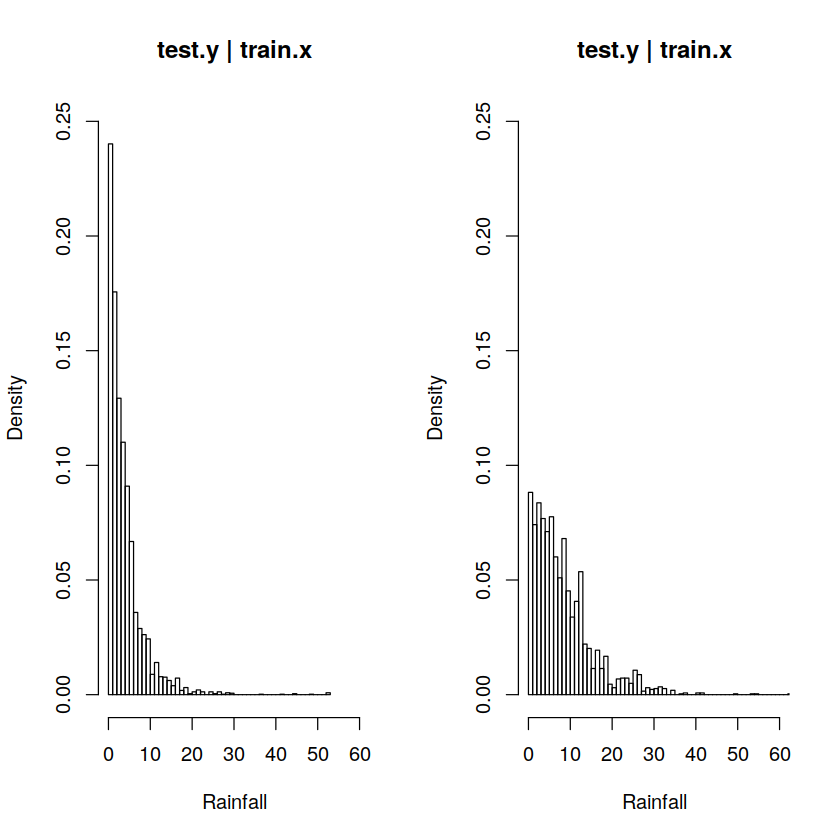

In [13]:
pr.leaves <- randomForestPredict(rf, newdata = test.x, method = "leaves")

par(mfrow = c(1,2))
hist(pr.leaves[[100]], breaks = 50, xlab = "Rainfall", freq = FALSE,
     main = "test.y | train.x", ylim = c(0, 0.25), xlim = c(0,60))
hist(pr.leaves[[300]], breaks = 50, xlab = "Rainfall", freq = FALSE, 
     main = "test.y | train.x",ylim = c(0, 0.25), xlim = c(0,60))

As the model was trained using the *deviation* for the 2 parameter gamma distribution, using `method = "aposteriori"` provides the shape and rate parameters for each prediction:

In [14]:
pr.distr <- randomForestPredict(rf, newdata = test.x, method = "aposteriori")
pr.distr[1:10,] # We show the first 10 predicted outcomes 

mean,sd
8.567043,8.929944
2.057696,2.355131
4.390519,4.311260
2.370429,2.563702
3.430964,3.611757
8.167465,6.278448
7.929120,5.945889
3.136086,3.263602
8.423594,5.928816
10.706578,5.797082


As stated above, the user can also specify the estimator used. For instance, rather than the Moments Matching Estimation (default) we could use the Maximum Likelihood Estimation by setting `method = "mle"`:

In [15]:
pr.mle <- randomForestPredict(rf, newdata = test.x, method = "mle")
pr.distr[1:10,] # We show the first 10 predicted outcomes 

mean,sd
8.567043,8.929944
2.057696,2.355131
4.390519,4.311260
2.370429,2.563702
3.430964,3.611757
8.167465,6.278448
7.929120,5.945889
3.136086,3.263602
8.423594,5.928816
10.706578,5.797082


Finally, the predicted distribution parameters can be used to simulate a series of stochastic rainfall values. This can be done using the function `randomForestSimulate()`. It takes as inputs the object returned by `randomForestPredict()` and the number of simulated series, `n`. The parameter `distr` allows for manually selecting the distribution of interest (by default, it is automatically selected based on the training split function considered).

In [16]:
simulation <- randomForestSimulate(pr.distr)

We simulate 1000 series:

In [17]:
simulations <- randomForestSimulate(pr.distr, n = 1000)
head(simulations)

19.130835,21.746864,2.5620741,24.4728991,-8.599635,0.9378861,3.6251788,20.9880400,-0.653134571,11.533108,⋯,-0.2496892,14.647168,-5.179861,-2.747446,12.4224818,3.264809,18.4600591,4.8889878,17.5396511,16.0125463
7.006280,6.521129,-5.8547134,1.6765677,3.276943,2.7772007,0.4449056,0.2937084,-0.006998182,2.625824,⋯,0.4470380,1.327248,5.227063,6.783584,0.6714375,4.138768,-0.5483795,4.2855998,2.6323914,0.6106512
2.076019,10.101233,0.4358133,5.2178859,7.616047,0.8833983,2.6504474,-2.0535395,12.894855456,8.270778,⋯,2.3122302,3.187010,5.928887,11.847694,4.3818374,10.539896,6.7767396,8.0162607,9.6356243,-1.4056331
4.343131,-1.113647,4.7924359,-0.5219222,2.309342,-1.7117722,3.2339886,5.2284008,5.846650687,1.656752,⋯,5.8442844,-1.795581,2.979367,7.816676,4.0688966,1.245108,4.4698922,4.9694939,1.3183008,6.2202809
5.317898,1.443337,1.0277138,8.4330255,2.390635,7.8563778,3.0647422,2.0999046,1.346990359,5.384209,⋯,8.1575668,5.651471,1.873463,3.499609,-1.3790015,6.818776,-6.1717950,0.7701276,0.1039932,1.8012089
1.687543,2.783779,4.4966187,4.2025480,14.675236,0.4887514,10.3709325,13.6400548,15.705154036,5.582356,⋯,14.0167407,12.037037,16.145484,2.732419,9.3700952,4.897159,8.3600116,5.5413052,11.7879221,16.0709561


# Reproducibility code for the final model in *Legasa et al. 2020*

Finally, we use the code below to train the final model in *Legasa et al. 2020*, and obtain a Figure similar to Figure 6 in *Legasa et al. 2020* (we reproduce here only the continuous part). We use a random forest with 25 trees, minimum leaf size 5 which considers the *deviation* as split function.

In [18]:
future::plan(future::multisession, workers = 6) ## Sets parallelization to 6 cores

predictions <-
lapply(VALUE9, function(meteorological.station){
    predictions <- lapply(meteorological.station, function(fold){
        # train the model:
        md <- randomForestTrain(x = fold$train.x, y = fold$train.y, 
                                ntree = 25, minbucket = 5, 
                                method = "gammaDeviation",
                                parallel.plan = NULL)
        
        #Use the function to predict for $test.x, an also return the observed values $test.y:        
        return(list(predicted = randomForestPredict(md, newdata = fold$test.x, method = "mme"),
                     observed = fold$test.y))
    })
    
    # rearange the series:    
    predicted <- do.call(rbind, lapply(predictions, function(pr) pr$predicted)) 
    attr(predicted, "class") <- "RandomForest2.prediction.simulable" # recovers the class
    observed <- do.call(c, lapply(predictions, function(pr) pr$observed))

    return(list(predicted = predicted, observed = observed))
})

future::plan(future::sequential) ## Reverts plan to normal

We end up with the downscaled probability distribution for each station and day. We validate them for the selected measures as follows:

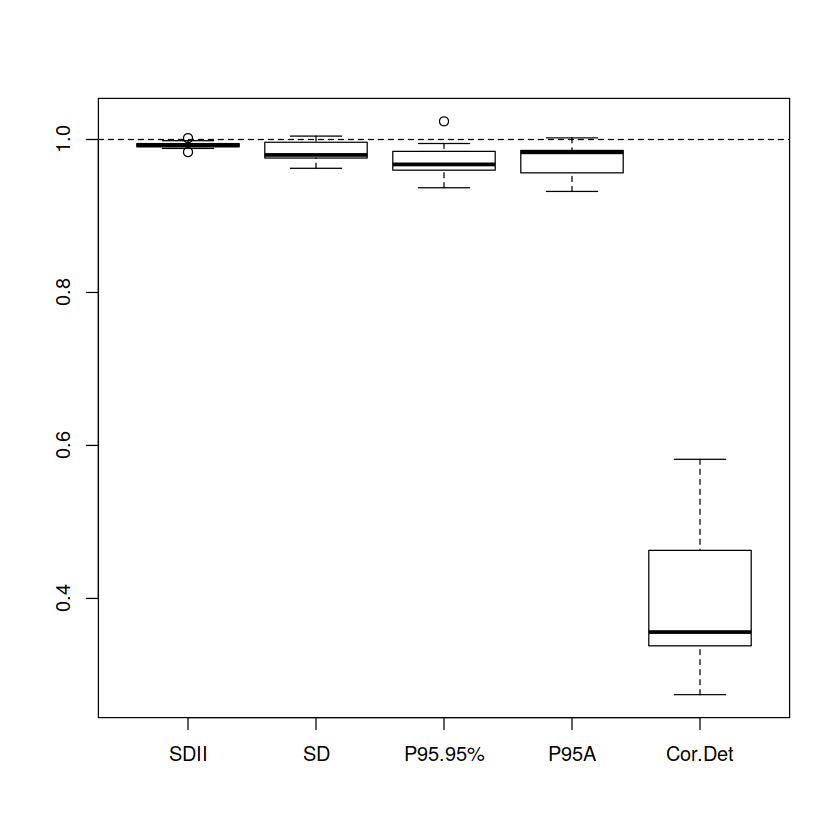

In [19]:
validation <- 
    lapply(predictions, function(station.predictions){ #for each meteorological station
        # Generate 250 simulations

        observed <- station.predictions$observed
        simulations <- randomForestSimulate(prediction = station.predictions$predicted, distr = "gamma", n = 250)


        # validate each simulation
        stochastic.validation <-
            apply(simulations, MARGIN = 2, FUN = function(simulation){

                P95.simulated <- quantile(simulation, probs = 0.95)
                P95.observed <- quantile(observed, probs = 0.95)

                return(
                    c(SDII = mean(simulation)/mean(observed),
                      SD = sd(simulation)/sd(observed),
                      P95 = P95.simulated/P95.observed,
                      P95A = sum(simulation[simulation >= P95.simulated])/sum(observed[observed >= P95.observed])
                     )
                )
            })

        # For each series we obtained the measures. We average them:
        stochastic.validation <- rowMeans(stochastic.validation)

        # We compute the deterministic correlation. Recall E[X] = alpha/beta:
        alphas <- station.predictions$predicted[ , 1]
        betas <- station.predictions$predicted[ , 2]
        correlation <- cor(alphas/betas, observed, method = "spearman")

        return(c(stochastic.validation, Cor.Det = correlation))

    })

validation <- t(simplify2array(validation))

# We plot the results:
boxplot(validation)   
abline(h = 1, lty = 2)